In [36]:
import os
from IPython.display import display
from datetime import datetime

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    auc
)

from sklearnex import patch_sklearn
import pickle
from imblearn.over_sampling import SMOTE

import optuna
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from lightgbm import early_stopping

FOLDER_TO_SAVE_MODELS = 'saved_models'


### Exploring and processing the data

In [8]:
# Reading the data 
df_orig = pd.read_csv('creditcard.csv')

In [9]:
# First glance at the dataset
df_orig.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [10]:
# Checking if we've got any missing value
df_orig.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [11]:
value_counts = df_orig['Class'].value_counts()
proportions = value_counts / len(df_orig)
pd.DataFrame({
    'Count': value_counts, 
    'Proportion': proportions
})

,Count,Proportion
Class,,
0,284315,0.998273
1,492,0.001727


We are dealing with an extremely imbalanced dataset, where only 0.17% of the transactions are fraudulant. It's really important to consider this class imbalance when building our model.

If I use the original data to calculate the correlation matrix, it will be influenced by the class imbalance, with non-fraud cases dominating the fraud cases. This could lead us to distorted results. 

In [12]:
# Oversampling the original data using the SMOTE algorithm
smote = SMOTE(random_state=1234)
X_smote, y_smote = smote.fit_resample(df_orig.drop(columns='Class'), df_orig['Class'])
df_smote = X_smote.join(y_smote)

Text(0.5, 1.05, 'Correlation heatmap:\noversampled data')

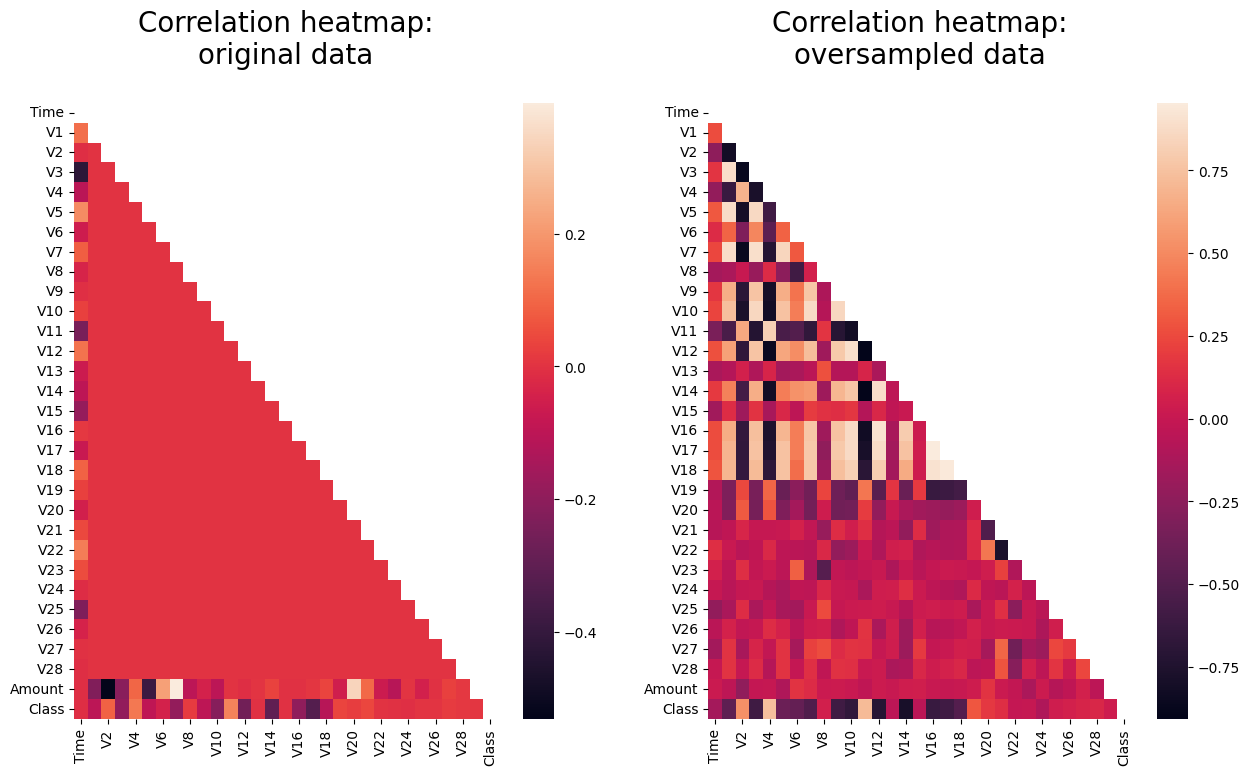

In [13]:
# Let's plot the correlation heatmaps for both the original data and the oversampled data.
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(8)
f.set_figwidth(15)
mask = np.triu(np.ones_like(df_orig.corr(), dtype=bool))
sns.heatmap(df_orig.corr(), mask = mask, ax=ax1)
ax1.set_title("Correlation heatmap:\noriginal data",fontsize=20, y=1.05)
sns.heatmap(df_smote.corr(), mask = mask, ax=ax2)
ax2.set_title("Correlation heatmap:\noversampled data",fontsize=20, y=1.05)

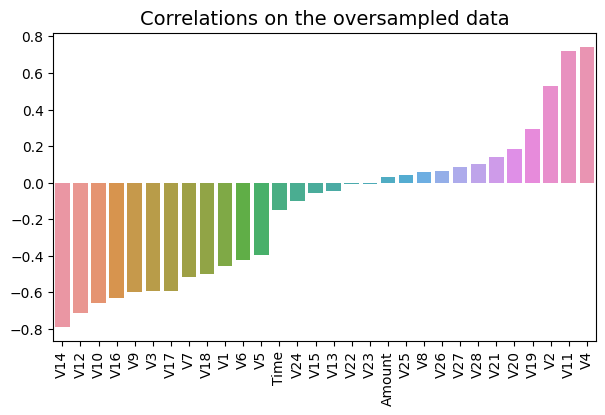

In [14]:
# Creating a pd Series containing the columns with their correlation values based on the oversampled dataset
correlations = df_smote.corr()['Class'].sort_values()
correlations = correlations.loc[correlations.index != 'Class']

# Plot the correlations on a barplot
plt.figure(figsize = (7,4))
plt.title('Correlations on the oversampled data',fontsize=14)
s = sns.barplot(y=correlations, x=correlations.index)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
s.set_ylabel("")
plt.show()  

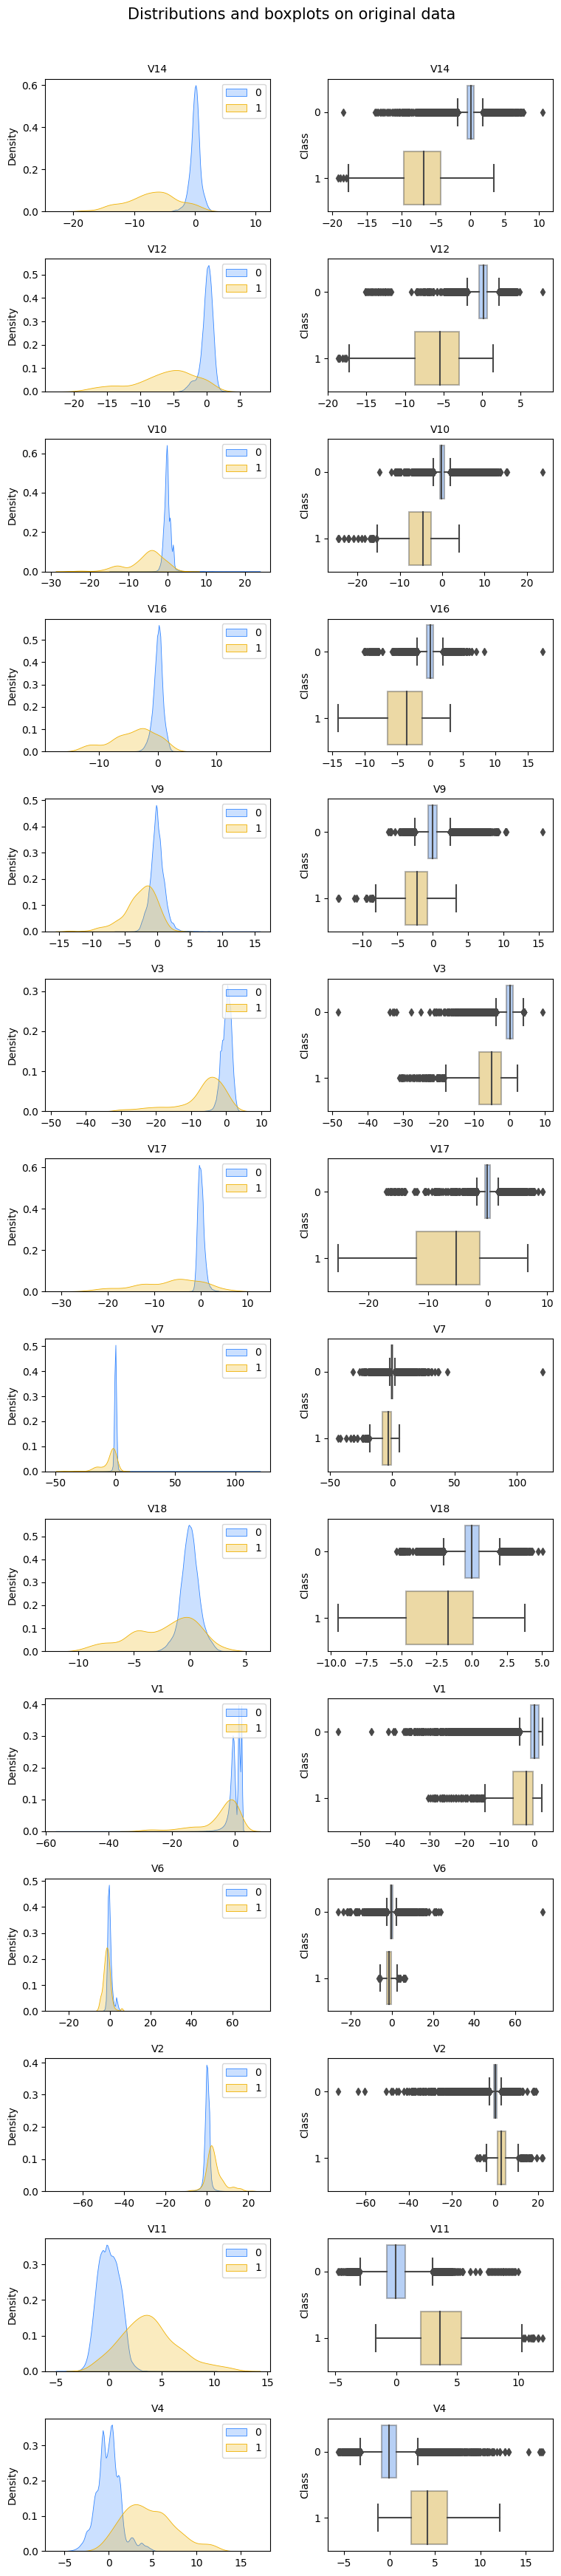

In [15]:
important_features = correlations[np.abs(correlations) > 0.4].index

f, axes = plt.subplots(len(important_features),2)
f.suptitle('Distributions and boxplots on original data',fontsize=15,y=1.0005)
f.set_figheight(2.5*len(important_features))
f.set_figwidth(8)
f.tight_layout(pad=2.5)

for i, feature in enumerate(important_features):

    sns.kdeplot(
        data = df_orig.loc[df_orig.Class == 0], 
        x = feature, 
        fill = True, 
        color ="#3386FF",
        linewidth=0.6, 
        ax=axes[i,0], 
        label=0
    )
    
    sns.kdeplot(
        data = df_orig.loc[df_orig.Class == 1], 
        x = feature, 
        fill = True, 
        color ="#EFB000",
        linewidth=0.6, 
        ax=axes[i,0], 
        label=1
    )
    
    axes[i,0].set_xlabel('')
    axes[i,0].legend()
    axes[i,0].set_title(feature,fontsize=10, y=1.00)


    sns.boxplot(x = df_orig[feature],
                y = df_orig['Class'],
                orient='h',
                palette= ["#3386FF","#EFB000"],
                ax=axes[i][1],
                boxprops=dict(alpha=.4)
    )
    axes[i,1].set_xlabel('')
    axes[i][1].set_title(feature,fontsize=10, y=1.00)


As the boxplots show us, our dataset contains several outliers. Removing these outliers would eliminate a significant number of observations from the fraud cases.

Additionally, this approach may lead to a loss of valuable information and potentially weaken the generalization capability of our model, i.e. it might achieve better results on this dataset but could perform poorly on unseen, real-life data.

Furthermore, considering the fact that we are working mostly with features that were transformed by PCA, I believe it is wiser to put the emphasis on building a robust model instead of trying to figure out what is considered to be an outlier. 

In [16]:
df = df_orig

X = df.drop(columns='Class')
y = df['Class']

In [17]:
# Splitting the dataset into a test and train set. 
# I will perform cross validation on the trainset, and eventually I will test on the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

Here, I am implementing some functions that will be used during the optimization and the evaluation process of our models."

In [18]:

def predict_threshold(threshold, model, x):
    """ 
    Make binary predictions based on the given threshold
    """

    return np.array([int(x[0] <threshold) for x in model.predict_proba(x)])


def optimize_objective(objective, n_trials, direction):
    """
    Optimize an objective function using Optuna.
    """
    
    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    return study


def evaluate_model(model, x_test, y_test):

    """
    Evaluate the model's performance on test data and print out and visualize some metrics.

    Returns:
    - results_df_diff_thresholds: A DataFrame containing metrics for different thresholds.
    - auc_precision_recall: Area Under the PR Curve (AUCPR).
    - lr_recall: Recall values for the Precision-Recall Curve.
    - lr_precision: Precision values for the Precision-Recall Curve.

    """

    # Get the results. 
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1]


    # dictionary to store the metrics on different thresholds
    results_on_diff_threshold = {
        'threshold': [],
        'precision': [],
        'recall': [],
        'FN': [],
        'FP': [],
        'TP': [],
        'TN': [],
    }
    
    # loop trough the different thresholds and populate the results_on_diff_threshold dict
    for i in np.linspace(0.1,0.9,9):

        results_on_diff_threshold['threshold'].append(i)

        y_pred_threshold = predict_threshold(i,model, X_test)

        recall = recall_score(y_test, y_pred_threshold)
        precision = precision_score(y_test, y_pred_threshold)

        results_on_diff_threshold['precision'].append(precision)
        results_on_diff_threshold['recall'].append(recall)

        cm_threshold = confusion_matrix(y_test, y_pred_threshold)
        tn, fp, fn, tp = cm_threshold.ravel()

        results_on_diff_threshold['FN'].append(fn)
        results_on_diff_threshold['FP'].append(fp)
        results_on_diff_threshold['TP'].append(tp)
        results_on_diff_threshold['TN'].append(tn)

    # Getting the data for the PR curve
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_proba)

    # auc score
    auc_precision_recall = auc(lr_recall, lr_precision)

    results_df_diff_thresholds = pd.DataFrame(results_on_diff_threshold)

    # Printing out the results
    print("-------------------- Evaulation scores --------------------\n")
    print(classification_report(y_test, y_pred))
    print("-----------------------------------------------------------")
    print(f"AUCPR score: {auc_precision_recall:.4f}\n")
    print("-----------------------------------------------------------")
    print("Metrics when different threshold is used on test data: ")

    display(results_df_diff_thresholds)
    print("\n")

    plt.figure(figsize = (5,5))
    plt.plot(lr_recall, lr_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.show()

    return results_df_diff_thresholds, auc_precision_recall, lr_recall, lr_precision

### Random forest - optimized with RandomSearchCV 

In [23]:
# Enable the intel extension to boost performance in time
patch_sklearn(['RandomForestClassifier'])


class_weights = {1: np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])}

param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500],
    'class_weight':[class_weights]
}



kfold = StratifiedKFold(n_splits=3)

model_rf = RandomizedSearchCV(
        RandomForestClassifier(n_jobs=-1),
        param_grid,
        cv=kfold,
        scoring= 'neg_log_loss',
        verbose=1,
        n_iter=30,
        random_state=42 
)


model_rf.fit(X_train, y_train)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(n_jobs=-1), n_iter=30,
                   param_distributions={'class_weight': [{1: 24.026793419648342}],
                                        'max_depth': [80, 90, 100, 110],
                                        'max_features': [2, 3],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [8, 10, 12],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='neg_log_loss', verbose=1)

-------------------- Evaulation scores --------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.85      0.87        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

-----------------------------------------------------------
AUCPR score: 0.8850

-----------------------------------------------------------
Metrics when different threshold is used on test data: 


,threshold,precision,recall,FN,FP,TP,TN
0,0.1,0.955224,0.653061,34,3,64,56861
1,0.2,0.961039,0.755102,24,3,74,56861
2,0.3,0.962500,0.785714,21,3,77,56861
3,0.4,0.929412,0.806122,19,6,79,56858
4,0.5,0.892473,0.846939,15,10,83,56854
5,0.6,0.848485,0.857143,14,15,84,56849
6,0.7,0.825243,0.867347,13,18,85,56846
7,0.8,0.781818,0.877551,12,24,86,56840
8,0.9,0.676923,0.897959,10,42,88,56822


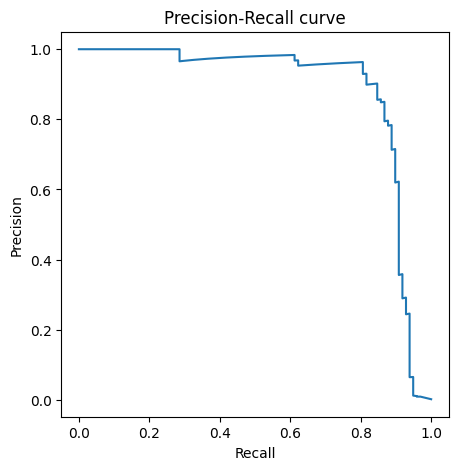

In [24]:
result_rf = evaluate_model(model_rf, X_test, y_test)

In [38]:
# Saving our model with the best performance

# Check if the folder exists
if not os.path.exists(FOLDER_TO_SAVE_MODELS):
    # If it doesn't exist, create the folder
    os.mkdir(FOLDER_TO_SAVE_MODELS)

filename = os.path.join(FOLDER_TO_SAVE_MODELS,f"Random-forest-{datetime.now().strftime('%Y%m%d')}.sav")
pickle.dump(model_rf, open(filename, 'wb'))

# Example to load rf model
# loaded_model_rf = pickle.load(open(filename, 'rb'))

### XGBOOST classifier - optimized with OPTUNA

In [26]:
def objective_xgb(
        trial,
        eval_metric='logloss',
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        y_test=y_test,
        seed=42,
        n_folds=3,
):
    
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_test, label=y_test)

    pos_weight = np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])

    param = {
        "verbosity":0,
        'objective':trial.suggest_categorical('objective',['binary:logistic']),
        "eval_metric": [eval_metric],
        'predictor': trial.suggest_categorical('predictor',['gpu_predictor']),
        'tree_method':trial.suggest_categorical('tree_method',['gpu_hist']),
        'lambda'           : trial.suggest_float('lambda', 1e-3, 5.0),
        'alpha'            : trial.suggest_float('alpha', 1e-3, 5.0),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 150),
        'subsample'        : trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        'max_depth'        : trial.suggest_int("max_depth", 1, 9),
        'eta'    : trial.suggest_categorical('eta', [0.001,0.01,0.05,0.1,0.2,0.25,0.3]),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight',[pos_weight])
    }

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f"test-{eval_metric}")

    xgb_cv_results = xgb.cv(
        params=param,
        dtrain=dtrain,
        num_boost_round=10000,
        callbacks=[pruning_callback],
        nfold=n_folds,
        stratified=True,
        early_stopping_rounds=100,
        seed=seed,
        verbose_eval=False,
    )

    # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
    trial.set_user_attr("n_estimators", len(xgb_cv_results))

    # Extract the best score.
    best_score = xgb_cv_results[f"test-{eval_metric}-mean"].values[-1]
    return best_score


In [27]:
study_xgb = optimize_objective(
    objective=objective_xgb,
    n_trials=30,
    direction="minimize"
)

[I 2023-10-12 18:06:22,907] A new study created in memory with name: no-name-a78e175b-7ee7-4d17-b61a-ed0c130554e5
[I 2023-10-12 18:06:27,204] Trial 0 finished with value: 0.004791392002898374 and parameters: {'objective': 'binary:logistic', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'lambda': 4.0297815833626585, 'alpha': 0.7087179669823224, 'min_child_weight': 65, 'subsample': 0.35344732889670044, 'colsample_bytree': 0.8290254897922171, 'max_depth': 9, 'eta': 0.1, 'scale_pos_weight': 24.026793419648342}. Best is trial 0 with value: 0.004791392002898374.
[I 2023-10-12 18:06:30,109] Trial 1 finished with value: 0.00641293592849644 and parameters: {'objective': 'binary:logistic', 'predictor': 'gpu_predictor', 'tree_method': 'gpu_hist', 'lambda': 0.8557084965014216, 'alpha': 2.731344925374908, 'min_child_weight': 94, 'subsample': 0.3484890559339651, 'colsample_bytree': 0.8024915531962971, 'max_depth': 7, 'eta': 0.25, 'scale_pos_weight': 24.026793419648342}. Best is trial 0 wi

Number of finished trials:  30
Best trial:
  Value: 0.0029228741673807466
  Params: 
    objective: binary:logistic
    predictor: gpu_predictor
    tree_method: gpu_hist
    lambda: 1.663105763055996
    alpha: 0.04909667577397725
    min_child_weight: 25
    subsample: 0.8051900287733712
    colsample_bytree: 0.41240258265544383
    max_depth: 5
    eta: 0.3
    scale_pos_weight: 24.026793419648342


In [39]:
optuna.visualization.plot_optimization_history(study_xgb)

-------------------- Evaulation scores --------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.87      0.88        98

    accuracy                           1.00     56962
   macro avg       0.94      0.93      0.94     56962
weighted avg       1.00      1.00      1.00     56962

-----------------------------------------------------------
AUCPR score: 0.8777

-----------------------------------------------------------
Metrics when different threshold is used on test data: 


,threshold,precision,recall,FN,FP,TP,TN
0,0.1,0.952381,0.816327,18,4,80,56860
1,0.2,0.954023,0.846939,15,4,83,56860
2,0.3,0.913043,0.857143,14,8,84,56856
3,0.4,0.893617,0.857143,14,10,84,56854
4,0.5,0.885417,0.867347,13,11,85,56853
5,0.6,0.817308,0.867347,13,19,85,56845
6,0.7,0.801887,0.867347,13,21,85,56843
7,0.8,0.741379,0.877551,12,30,86,56834
8,0.9,0.639706,0.887755,11,49,87,56815


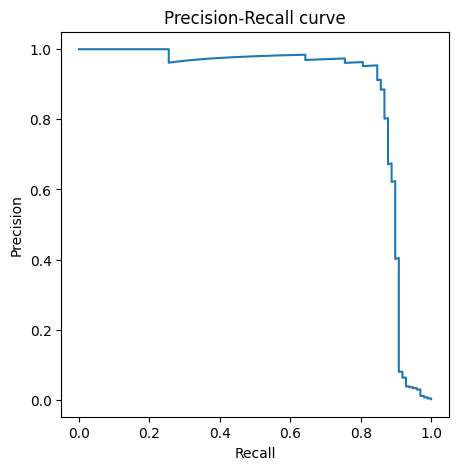

In [40]:
def create_fit_xgb(study, x, y):

    model = xgb.XGBClassifier(
        **study.best_params, 
        n_estimators = study.best_trial.user_attrs['n_estimators']
    )
    model.fit(x, y)

    return model

model_xgb = create_fit_xgb(study_xgb, X_train, y_train)
result_xgb = evaluate_model(model_xgb, X_test, y_test)

In [41]:
# Saving the model with the best performance
model_xgb.save_model(os.path.join(FOLDER_TO_SAVE_MODELS,f"XGB-{datetime.now().strftime('%Y%m%d')}.json"))

# Example to load model
# loaded_model_xgb = xgb.XGBClassifier()
# loaded_model_xgb.load_model("model_sklearn.json")

### CATBOOST + OPTUNA

In [42]:
def objective_cb(
        trial,
        eval_metric='Logloss', 
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        y_test=y_test,
        seed=42,
        n_folds=3
):
    
        train_pool = cb.Pool(data=x_train, label=y_train, has_header=True)
        test_pool = cb.Pool(data=x_test, label=y_test, has_header=True)

        pos_weight = np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])

        params = {
                "objective": trial.suggest_categorical("objective", ["Logloss"]),
                # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
                "depth": trial.suggest_int("depth", 1, 12),
                "learning_rate":trial.suggest_float("learning_rate", 1e-3, 1, log=True),
                # With this amount of data ordered boosting_type would make our training 
                "boosting_type": trial.suggest_categorical("boosting_type", ["Plain"]),
                "bootstrap_type": trial.suggest_categorical(
                "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
                ),
                "scale_pos_weight": trial.suggest_categorical('scale_pos_weight',[pos_weight]),
                "task_type":trial.suggest_categorical("task_type",["GPU"]),
                "verbose": False

        }

        if params["bootstrap_type"] == "Bayesian":
                params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        elif params["bootstrap_type"] == "Bernoulli":
                params["subsample"] = trial.suggest_float("subsample", 0.1, 1)


        catboost_cv_results = cb.cv(train_pool,
                params,
                nfold=n_folds,
                stratified=True,
                early_stopping_rounds=100,
                seed=seed,
                verbose=0
                
        )


        # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
        trial.set_user_attr("iterations", len(catboost_cv_results))

        # Extract the best score.
        best_score = catboost_cv_results[F"test-{eval_metric}-mean"].values[-1]
        return best_score


In [48]:
study_cb = optimize_objective(
    objective=objective_cb,
    n_trials=30,
    direction="minimize"
)

[I 2023-10-12 18:26:29,971] A new study created in memory with name: no-name-108a6b86-29e7-4c2a-b1d2-cf214e01dc50


Training on fold [0/3]
bestTest = 0.04142926884
bestIteration = 22
Training on fold [1/3]
bestTest = 0.03097950667
bestIteration = 36
Training on fold [2/3]


[I 2023-10-12 18:26:33,999] Trial 0 finished with value: 0.04989384300166825 and parameters: {'objective': 'Logloss', 'depth': 9, 'learning_rate': 0.08030623475741054, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU'}. Best is trial 0 with value: 0.04989384300166825.


bestTest = 0.04587165982
bestIteration = 29
Training on fold [0/3]
bestTest = 0.03724731552
bestIteration = 117
Training on fold [1/3]
bestTest = 0.02764737249
bestIteration = 119
Training on fold [2/3]


[I 2023-10-12 18:26:45,277] Trial 1 finished with value: 0.03834422317627186 and parameters: {'objective': 'Logloss', 'depth': 10, 'learning_rate': 0.017269472897444998, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 6.895388079824291}. Best is trial 1 with value: 0.03834422317627186.


bestTest = 0.04448728602
bestIteration = 92
Training on fold [0/3]
bestTest = 0.03779612123
bestIteration = 999
Training on fold [1/3]
bestTest = 0.0302523054
bestIteration = 963
Training on fold [2/3]


[I 2023-10-12 18:26:52,158] Trial 2 finished with value: 0.03839170732084173 and parameters: {'objective': 'Logloss', 'depth': 3, 'learning_rate': 0.009133570886478112, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 8.242006629456144}. Best is trial 1 with value: 0.03834422317627186.


bestTest = 0.04710759743
bestIteration = 997
Training on fold [0/3]
bestTest = 0.03458487269
bestIteration = 314
Training on fold [1/3]
bestTest = 0.02751873913
bestIteration = 317
Training on fold [2/3]


[I 2023-10-12 18:27:00,420] Trial 3 finished with value: 0.03630916759931572 and parameters: {'objective': 'Logloss', 'depth': 8, 'learning_rate': 0.012457552077016924, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 4.181371323707541}. Best is trial 3 with value: 0.03630916759931572.


bestTest = 0.0454217136
bestIteration = 175
Training on fold [0/3]
bestTest = 0.0381094547
bestIteration = 221
Training on fold [1/3]
bestTest = 0.03101635755
bestIteration = 356
Training on fold [2/3]


[I 2023-10-12 18:27:04,776] Trial 4 finished with value: 0.03909154679158068 and parameters: {'objective': 'Logloss', 'depth': 3, 'learning_rate': 0.03584511639218657, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU'}. Best is trial 3 with value: 0.03630916759931572.


bestTest = 0.0479142388
bestIteration = 970
Training on fold [0/3]
bestTest = 0.03720604977
bestIteration = 99
Training on fold [1/3]
bestTest = 0.02997433615
bestIteration = 300
Training on fold [2/3]


[I 2023-10-12 18:27:07,449] Trial 5 finished with value: 0.03887408687380751 and parameters: {'objective': 'Logloss', 'depth': 5, 'learning_rate': 0.05382468847667113, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 9.767255997791292}. Best is trial 3 with value: 0.03630916759931572.


bestTest = 0.04498665119
bestIteration = 155
Training on fold [0/3]
bestTest = 0.03629867312
bestIteration = 192
Training on fold [1/3]
bestTest = 0.02746652212
bestIteration = 307
Training on fold [2/3]


[I 2023-10-12 18:27:17,040] Trial 6 finished with value: 0.037774667606589346 and parameters: {'objective': 'Logloss', 'depth': 9, 'learning_rate': 0.009674255436332857, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 6.65547844017285}. Best is trial 3 with value: 0.03630916759931572.


bestTest = 0.04751522032
bestIteration = 178
Training on fold [0/3]
bestTest = 0.04714955894
bestIteration = 999
Training on fold [1/3]
bestTest = 0.04042902343
bestIteration = 999
Training on fold [2/3]


[I 2023-10-12 18:27:21,951] Trial 7 finished with value: 0.047546228750318165 and parameters: {'objective': 'Logloss', 'depth': 1, 'learning_rate': 0.002138456217312663, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.7193043253606086}. Best is trial 3 with value: 0.03630916759931572.


bestTest = 0.05506010389
bestIteration = 999
Training on fold [0/3]
bestTest = 0.03624327607
bestIteration = 54
Training on fold [1/3]
bestTest = 0.02859251616
bestIteration = 72
Training on fold [2/3]


[I 2023-10-12 18:27:25,158] Trial 8 finished with value: 0.04134986767310544 and parameters: {'objective': 'Logloss', 'depth': 8, 'learning_rate': 0.04601276989231925, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.2087221893688722}. Best is trial 3 with value: 0.03630916759931572.


bestTest = 0.04427589199
bestIteration = 67
Training on fold [0/3]
bestTest = 0.03754046584
bestIteration = 11
Training on fold [1/3]
bestTest = 0.02881526319
bestIteration = 13
Training on fold [2/3]


[I 2023-10-12 18:27:27,461] Trial 9 finished with value: 0.059932532401659966 and parameters: {'objective': 'Logloss', 'depth': 8, 'learning_rate': 0.24651901621627537, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.2837068499642318}. Best is trial 3 with value: 0.03630916759931572.


bestTest = 0.0471711829
bestIteration = 5
Training on fold [0/3]
bestTest = 0.05231904665
bestIteration = 0
Training on fold [1/3]
bestTest = 0.03892723942
bestIteration = 0
Training on fold [2/3]


[I 2023-10-12 18:27:44,765] Trial 10 finished with value: 0.09397863888602508 and parameters: {'objective': 'Logloss', 'depth': 12, 'learning_rate': 0.8872335581303664, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 2.102328943974918}. Best is trial 3 with value: 0.03630916759931572.


bestTest = 0.05252319005
bestIteration = 0
Training on fold [0/3]
bestTest = 0.0346589693
bestIteration = 999
Training on fold [1/3]
bestTest = 0.02782136839
bestIteration = 996
Training on fold [2/3]


[I 2023-10-12 18:27:54,717] Trial 11 finished with value: 0.03616606302034389 and parameters: {'objective': 'Logloss', 'depth': 6, 'learning_rate': 0.005351567179807343, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 4.173359650186536}. Best is trial 11 with value: 0.03616606302034389.


bestTest = 0.04581247703
bestIteration = 483
Training on fold [0/3]
bestTest = 0.03738805673
bestIteration = 999
Training on fold [1/3]
bestTest = 0.03058739831
bestIteration = 999
Training on fold [2/3]


[I 2023-10-12 18:28:06,080] Trial 12 finished with value: 0.037811747955074436 and parameters: {'objective': 'Logloss', 'depth': 6, 'learning_rate': 0.0024676767220064393, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 3.631738693496008}. Best is trial 11 with value: 0.03616606302034389.


bestTest = 0.04545973627
bestIteration = 997
Training on fold [0/3]
bestTest = 0.05657553548
bestIteration = 999
Training on fold [1/3]
bestTest = 0.05314707961
bestIteration = 999
Training on fold [2/3]


[I 2023-10-12 18:28:15,386] Trial 13 finished with value: 0.05604879127052767 and parameters: {'objective': 'Logloss', 'depth': 5, 'learning_rate': 0.0010825782991601765, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 4.125390281601066}. Best is trial 11 with value: 0.03616606302034389.


bestTest = 0.05842375872
bestIteration = 999
Training on fold [0/3]
bestTest = 0.0355215752
bestIteration = 490
Training on fold [1/3]
bestTest = 0.02835055374
bestIteration = 751
Training on fold [2/3]


[I 2023-10-12 18:28:24,824] Trial 14 finished with value: 0.03632200679537766 and parameters: {'objective': 'Logloss', 'depth': 7, 'learning_rate': 0.005603158930395397, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 0.645149618415195}. Best is trial 11 with value: 0.03616606302034389.


bestTest = 0.04477164597
bestIteration = 356
Training on fold [0/3]
bestTest = 0.03696906922
bestIteration = 234
Training on fold [1/3]
bestTest = 0.03073783797
bestIteration = 238
Training on fold [2/3]


[I 2023-10-12 18:28:27,794] Trial 15 finished with value: 0.03876900031260981 and parameters: {'objective': 'Logloss', 'depth': 4, 'learning_rate': 0.01655067302375426, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU'}. Best is trial 11 with value: 0.03616606302034389.


bestTest = 0.04811163944
bestIteration = 241
Training on fold [0/3]
bestTest = 0.03503176118
bestIteration = 441
Training on fold [1/3]
bestTest = 0.02757028832
bestIteration = 550
Training on fold [2/3]


[I 2023-10-12 18:29:16,756] Trial 16 finished with value: 0.035557243232131275 and parameters: {'objective': 'Logloss', 'depth': 11, 'learning_rate': 0.00434989029126983, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 4.80789382081378}. Best is trial 16 with value: 0.035557243232131275.


bestTest = 0.04267306874
bestIteration = 366
Training on fold [0/3]
bestTest = 0.03340444234
bestIteration = 373
Training on fold [1/3]
bestTest = 0.027876368
bestIteration = 554
Training on fold [2/3]


[I 2023-10-12 18:30:03,467] Trial 17 finished with value: 0.03598731655679207 and parameters: {'objective': 'Logloss', 'depth': 11, 'learning_rate': 0.0044541051205298264, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 5.527005094779235}. Best is trial 16 with value: 0.035557243232131275.


bestTest = 0.04536293893
bestIteration = 315
Training on fold [0/3]
bestTest = 0.03680753905
bestIteration = 995
Training on fold [1/3]
bestTest = 0.02899188092
bestIteration = 999
Training on fold [2/3]


[I 2023-10-12 18:31:24,558] Trial 18 finished with value: 0.03710629820013898 and parameters: {'objective': 'Logloss', 'depth': 12, 'learning_rate': 0.0027595105660017417, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU'}. Best is trial 16 with value: 0.035557243232131275.


bestTest = 0.04549785478
bestIteration = 991
Training on fold [0/3]
bestTest = 0.03560079023
bestIteration = 351
Training on fold [1/3]
bestTest = 0.02780521695
bestIteration = 377
Training on fold [2/3]


[I 2023-10-12 18:32:01,922] Trial 19 finished with value: 0.036523309976012684 and parameters: {'objective': 'Logloss', 'depth': 11, 'learning_rate': 0.00504769636981087, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'subsample': 0.9764217558869108}. Best is trial 16 with value: 0.035557243232131275.


bestTest = 0.04379713042
bestIteration = 299
Training on fold [0/3]
bestTest = 0.03544129692
bestIteration = 78
Training on fold [1/3]
bestTest = 0.02867119569
bestIteration = 114
Training on fold [2/3]


[I 2023-10-12 18:32:17,988] Trial 20 finished with value: 0.03989779409352422 and parameters: {'objective': 'Logloss', 'depth': 11, 'learning_rate': 0.022547921419213038, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 5.837959992428098}. Best is trial 16 with value: 0.035557243232131275.


bestTest = 0.0438840248
bestIteration = 74
Training on fold [0/3]
bestTest = 0.03485307069
bestIteration = 372
Training on fold [1/3]
bestTest = 0.02862783043
bestIteration = 426
Training on fold [2/3]


[I 2023-10-12 18:32:39,591] Trial 21 finished with value: 0.03703540000571657 and parameters: {'objective': 'Logloss', 'depth': 10, 'learning_rate': 0.0058784047875989716, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 5.25420776934679}. Best is trial 16 with value: 0.035557243232131275.


bestTest = 0.04603285267
bestIteration = 283
Training on fold [0/3]
bestTest = 0.05260150577
bestIteration = 999
Training on fold [1/3]
bestTest = 0.04912396742
bestIteration = 999
Training on fold [2/3]


[I 2023-10-12 18:32:49,415] Trial 22 finished with value: 0.05238822198645341 and parameters: {'objective': 'Logloss', 'depth': 6, 'learning_rate': 0.001090146181699897, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 3.209431048277238}. Best is trial 16 with value: 0.035557243232131275.


bestTest = 0.05543919277
bestIteration = 999
Training on fold [0/3]
bestTest = 0.03603526901
bestIteration = 473
Training on fold [1/3]
bestTest = 0.02742105137
bestIteration = 623
Training on fold [2/3]


[I 2023-10-12 18:33:17,129] Trial 23 finished with value: 0.03659954598420767 and parameters: {'objective': 'Logloss', 'depth': 10, 'learning_rate': 0.00411093044871644, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 5.598636350630215}. Best is trial 16 with value: 0.035557243232131275.


bestTest = 0.04557532851
bestIteration = 377
Training on fold [0/3]
bestTest = 0.03475385796
bestIteration = 516
Training on fold [1/3]
bestTest = 0.02737074198
bestIteration = 551
Training on fold [2/3]


[I 2023-10-12 18:33:24,486] Trial 24 finished with value: 0.03618228600195895 and parameters: {'objective': 'Logloss', 'depth': 7, 'learning_rate': 0.00884558777440683, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 4.728399145064696}. Best is trial 16 with value: 0.035557243232131275.


bestTest = 0.04578401105
bestIteration = 312
Training on fold [0/3]
bestTest = 0.03529296153
bestIteration = 975
Training on fold [1/3]
bestTest = 0.02831276915
bestIteration = 998
Training on fold [2/3]


[I 2023-10-12 18:34:46,595] Trial 25 finished with value: 0.03568870448848911 and parameters: {'objective': 'Logloss', 'depth': 11, 'learning_rate': 0.0019930858780542768, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 2.6903229996210323}. Best is trial 16 with value: 0.035557243232131275.


bestTest = 0.04334369668
bestIteration = 785
Training on fold [0/3]
bestTest = 0.03574602551
bestIteration = 999
Training on fold [1/3]
bestTest = 0.02903096716
bestIteration = 999
Training on fold [2/3]


[I 2023-10-12 18:36:12,444] Trial 26 finished with value: 0.036081641034291755 and parameters: {'objective': 'Logloss', 'depth': 11, 'learning_rate': 0.00172880991991602, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 2.763524417228804}. Best is trial 16 with value: 0.035557243232131275.


bestTest = 0.04332870466
bestIteration = 883
Training on fold [0/3]
bestTest = 0.03564088764
bestIteration = 689
Training on fold [1/3]
bestTest = 0.02831622884
bestIteration = 754
Training on fold [2/3]


[I 2023-10-12 18:38:13,197] Trial 27 finished with value: 0.0359613544716977 and parameters: {'objective': 'Logloss', 'depth': 12, 'learning_rate': 0.002775482343741305, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'scale_pos_weight': 24.026793419648342, 'task_type': 'GPU', 'bagging_temperature': 1.9788178450408211}. Best is trial 16 with value: 0.035557243232131275.


bestTest = 0.04295237673
bestIteration = 561
Number of finished trials:  28
Best trial:
  Value: 0.035557243232131275
  Params: 
    objective: Logloss
    depth: 11
    learning_rate: 0.00434989029126983
    boosting_type: Plain
    bootstrap_type: Bayesian
    scale_pos_weight: 24.026793419648342
    task_type: GPU
    bagging_temperature: 4.80789382081378


In [49]:
optuna.visualization.plot_optimization_history(study_cb)

In [50]:
def create_fit_cb(study, x, y):

    model = cb.CatBoostClassifier(
        **study.best_params,
        iterations=study_cb.best_trial.user_attrs['iterations']
    )
    model.fit(x, y,verbose=True)

    return model


model_cb = create_fit_cb(study_cb, X_train, y_train)

0:	learn: 0.6810953	total: 29.2ms	remaining: 19s
1:	learn: 0.6689684	total: 59.4ms	remaining: 19.3s
2:	learn: 0.6574052	total: 87.3ms	remaining: 18.9s
3:	learn: 0.6467979	total: 114ms	remaining: 18.5s
4:	learn: 0.6342787	total: 145ms	remaining: 18.8s
5:	learn: 0.6216617	total: 190ms	remaining: 20.4s
6:	learn: 0.6080469	total: 229ms	remaining: 21.1s
7:	learn: 0.5955597	total: 260ms	remaining: 20.9s
8:	learn: 0.5849274	total: 290ms	remaining: 20.7s
9:	learn: 0.5721821	total: 317ms	remaining: 20.3s
10:	learn: 0.5623065	total: 343ms	remaining: 19.9s
11:	learn: 0.5516650	total: 370ms	remaining: 19.7s
12:	learn: 0.5419122	total: 397ms	remaining: 19.5s
13:	learn: 0.5315838	total: 422ms	remaining: 19.2s
14:	learn: 0.5219784	total: 450ms	remaining: 19.1s
15:	learn: 0.5113101	total: 476ms	remaining: 18.9s
16:	learn: 0.5021598	total: 504ms	remaining: 18.8s
17:	learn: 0.4928535	total: 530ms	remaining: 18.6s
18:	learn: 0.4836105	total: 558ms	remaining: 18.5s
19:	learn: 0.4745087	total: 583ms	remain

-------------------- Evaulation scores --------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.84      0.86      0.85        98

    accuracy                           1.00     56962
   macro avg       0.92      0.93      0.92     56962
weighted avg       1.00      1.00      1.00     56962

-----------------------------------------------------------
AUCPR score: 0.8847

-----------------------------------------------------------
Metrics when different threshold is used on test data: 


,threshold,precision,recall,FN,FP,TP,TN
0,0.1,0.939759,0.795918,20,5,78,56859
1,0.2,0.847826,0.795918,20,14,78,56850
2,0.3,0.851064,0.816327,18,14,80,56850
3,0.4,0.838384,0.846939,15,16,83,56848
4,0.5,0.840000,0.857143,14,16,84,56848
5,0.6,0.831683,0.857143,14,17,84,56847
6,0.7,0.796296,0.877551,12,22,86,56842
7,0.8,0.754386,0.877551,12,28,86,56836
8,0.9,0.640288,0.908163,9,50,89,56814


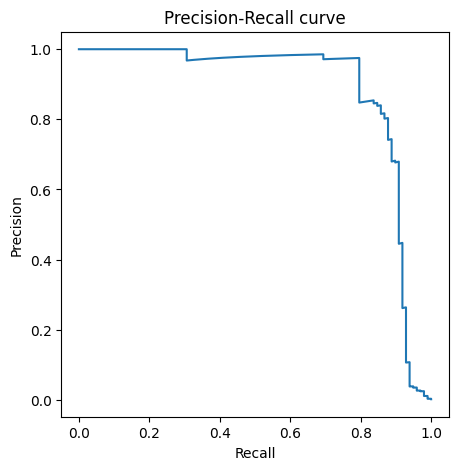

In [51]:
result_cb = evaluate_model(model_cb, X_test, y_test)

In [52]:
# Saving the model with the best performance
model_cb.save_model(os.path.join(FOLDER_TO_SAVE_MODELS,f"CatBoost-{datetime.now().strftime('%Y%m%d')}"))

# Example to load model
# loaded_model_xgb = cb.CatBoostClassifier()
# loaded_model_xgb.load_model('model_name')

In [54]:
def objective_lgb(
        trial,
        eval_metric='binary_logloss', 
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        y_test=y_test,
        seed=42,
        n_folds=3,
):
    
    dtrain = lgb.Dataset(x_train, label=y_train)

    pos_weight = np.sqrt(y_train.value_counts()[0] / y_train.value_counts()[1])

    params = {
        "objective": "binary",
        "metric": eval_metric,
        "verbosity": -1,
        "boosting_type": "gbdt",
        # "max_depth":trial.suggest_int("max_depth", 2, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'device':'gpu',
        "scale_pos_weight":pos_weight
    }


    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, f"valid {eval_metric}")

    lgb_cv_results = lgb.cv(
        params=params,
        train_set=dtrain,
        return_cvbooster=True,
        num_boost_round=10000,
        callbacks=[pruning_callback, early_stopping(100)],
        nfold=n_folds,
        stratified=True,
        seed=seed
    )


    # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
    trial.set_user_attr("iterations", lgb_cv_results["cvbooster"].best_iteration)


    best_score = lgb_cv_results[f'valid {eval_metric}-mean'][-1]
    return best_score

In [55]:
study_lgb = optimize_objective(
    objective=objective_lgb,
    n_trials=30,
    direction="minimize"
)

[I 2023-10-12 18:39:25,774] A new study created in memory with name: no-name-a30aeaa1-4c76-4352-9ea8-8d7f6d638cc2


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 18:39:35,437] Trial 0 finished with value: 0.12435565691025574 and parameters: {'lambda_l1': 0.025368010474191825, 'lambda_l2': 7.234795521063468e-07, 'num_leaves': 59, 'feature_fraction': 0.5428785129831782, 'bagging_fraction': 0.45521106534768796, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 0 with value: 0.12435565691025574.


Early stopping, best iteration is:
[2]	cv_agg's valid binary_logloss: 0.124356 + 0.0134977
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 18:40:08,492] Trial 1 finished with value: 0.005083024564757322 and parameters: {'lambda_l1': 1.459630507633882, 'lambda_l2': 1.6355416579886801, 'num_leaves': 40, 'feature_fraction': 0.6682933088743769, 'bagging_fraction': 0.5353219178106631, 'bagging_freq': 5, 'min_child_samples': 23}. Best is trial 1 with value: 0.005083024564757322.


Early stopping, best iteration is:
[389]	cv_agg's valid binary_logloss: 0.00508302 + 0.000475428
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 18:40:39,325] Trial 2 finished with value: 0.08333473108033966 and parameters: {'lambda_l1': 0.001639751008831318, 'lambda_l2': 0.00031808205512669295, 'num_leaves': 112, 'feature_fraction': 0.7323396251593399, 'bagging_fraction': 0.48862524067572216, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 1 with value: 0.005083024564757322.


Early stopping, best iteration is:
[27]	cv_agg's valid binary_logloss: 0.0833347 + 0.0242188
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 18:41:00,240] Trial 3 finished with value: 0.003493516439646569 and parameters: {'lambda_l1': 5.381822997529762, 'lambda_l2': 4.027227743675092, 'num_leaves': 39, 'feature_fraction': 0.6130634081056372, 'bagging_fraction': 0.7619805163613693, 'bagging_freq': 4, 'min_child_samples': 50}. Best is trial 3 with value: 0.003493516439646569.


Early stopping, best iteration is:
[388]	cv_agg's valid binary_logloss: 0.00349352 + 0.000559884
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 18:41:19,500] Trial 4 finished with value: 0.08890688725561045 and parameters: {'lambda_l1': 1.3570036488762727e-07, 'lambda_l2': 2.5180848527972203e-07, 'num_leaves': 188, 'feature_fraction': 0.768342826975819, 'bagging_fraction': 0.5921792716463028, 'bagging_freq': 4, 'min_child_samples': 43}. Best is trial 3 with value: 0.003493516439646569.


Early stopping, best iteration is:
[2]	cv_agg's valid binary_logloss: 0.0889069 + 0.00948909


[I 2023-10-12 18:41:19,962] Trial 5 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 18:41:32,337] Trial 6 finished with value: 0.058543750033171506 and parameters: {'lambda_l1': 6.165877458146238, 'lambda_l2': 0.007347245279681664, 'num_leaves': 12, 'feature_fraction': 0.8940148597162677, 'bagging_fraction': 0.9963866319516612, 'bagging_freq': 3, 'min_child_samples': 79}. Best is trial 3 with value: 0.003493516439646569.


Early stopping, best iteration is:
[1]	cv_agg's valid binary_logloss: 0.0585438 + 0.00232983
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 18:42:08,402] Trial 7 pruned. Trial was pruned at iteration 102.
[I 2023-10-12 18:42:08,842] Trial 8 pruned. Trial was pruned at iteration 1.


Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 18:42:24,315] Trial 9 pruned. Trial was pruned at iteration 102.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 18:43:52,517] Trial 10 finished with value: 0.003619732318959535 and parameters: {'lambda_l1': 2.3031339656464772e-05, 'lambda_l2': 7.094154276946561, 'num_leaves': 236, 'feature_fraction': 0.4068383253726928, 'bagging_fraction': 0.4036629860420049, 'bagging_freq': 1, 'min_child_samples': 69}. Best is trial 3 with value: 0.003493516439646569.


Early stopping, best iteration is:
[342]	cv_agg's valid binary_logloss: 0.00361973 + 0.000644224
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 18:45:18,634] Trial 11 finished with value: 0.003514476260402339 and parameters: {'lambda_l1': 8.797487545914423e-05, 'lambda_l2': 9.46742001252798, 'num_leaves': 244, 'feature_fraction': 0.45129872543263017, 'bagging_fraction': 0.40127475183425443, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 3 with value: 0.003493516439646569.


Early stopping, best iteration is:
[292]	cv_agg's valid binary_logloss: 0.00351448 + 0.000512878
Training until validation scores don't improve for 100 rounds


[I 2023-10-12 18:46:13,026] Trial 12 finished with value: 0.0032680373535126078 and parameters: {'lambda_l1': 9.673697112875202e-05, 'lambda_l2': 9.914178275772558, 'num_leaves': 246, 'feature_fraction': 0.5709905261456337, 'bagging_fraction': 0.7307804385113605, 'bagging_freq': 2, 'min_child_samples': 88}. Best is trial 12 with value: 0.0032680373535126078.


Early stopping, best iteration is:
[200]	cv_agg's valid binary_logloss: 0.00326804 + 0.00052


[I 2023-10-12 18:46:13,551] Trial 13 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 18:46:14,016] Trial 14 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 18:46:17,299] Trial 15 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 18:46:19,593] Trial 16 pruned. Trial was pruned at iteration 9.
[I 2023-10-12 18:46:21,768] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 18:46:28,454] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 18:46:28,955] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 18:46:29,700] Trial 20 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 18:46:59,303] Trial 21 finished with value: 0.003456621071193402 and parameters: {'lambda_l1': 0.00019733877235590468, 'lambda_l2': 9.294350229958114, 'num_leaves': 248, 'feature_fraction': 0.47724500942553794, 'bagging_fraction': 0.7460323810331488, 'bagging_freq': 1, 'min_child_samples': 76}. Best is trial 12 with value: 0.0032680373535126078.


Early stopping, best iteration is:
[210]	cv_agg's valid binary_logloss: 0.00345662 + 0.000506202


[I 2023-10-12 18:46:59,813] Trial 22 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 18:47:00,270] Trial 23 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 18:47:00,718] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 18:47:01,355] Trial 25 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 18:47:19,435] Trial 26 finished with value: 0.0031973715177970904 and parameters: {'lambda_l1': 0.008376259037270278, 'lambda_l2': 9.721300586303567, 'num_leaves': 254, 'feature_fraction': 0.5396652026281824, 'bagging_fraction': 0.7058147069787218, 'bagging_freq': 6, 'min_child_samples': 51}. Best is trial 26 with value: 0.0031973715177970904.


Early stopping, best iteration is:
[185]	cv_agg's valid binary_logloss: 0.00319737 + 0.000528615


[I 2023-10-12 18:47:19,981] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2023-10-12 18:47:20,506] Trial 28 pruned. Trial was pruned at iteration 5.


Training until validation scores don't improve for 100 rounds


[I 2023-10-12 18:47:21,745] Trial 29 pruned. Trial was pruned at iteration 0.


Number of finished trials:  30
Best trial:
  Value: 0.0031973715177970904
  Params: 
    lambda_l1: 0.008376259037270278
    lambda_l2: 9.721300586303567
    num_leaves: 254
    feature_fraction: 0.5396652026281824
    bagging_fraction: 0.7058147069787218
    bagging_freq: 6
    min_child_samples: 51


In [56]:
optuna.visualization.plot_optimization_history(study_lgb)

In [57]:
def create_fit_lgb(study, x, y):

    model = lgb.LGBMClassifier(
        **study.best_params, 
        n_estimators = study.best_trial.user_attrs['iterations'],
        verbosity=-1
    )
    model.fit(x, y)

    return model

model_lgb = create_fit_lgb(study_lgb, X_train, y_train)

-------------------- Evaulation scores --------------------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.95      0.82      0.88        98

    accuracy                           1.00     56962
   macro avg       0.98      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

-----------------------------------------------------------
AUCPR score: 0.8877

-----------------------------------------------------------
Metrics when different threshold is used on test data: 


,threshold,precision,recall,FN,FP,TP,TN
0,0.1,0.986667,0.755102,24,1,74,56863
1,0.2,0.987013,0.775510,22,1,76,56863
2,0.3,0.963415,0.806122,19,3,79,56861
3,0.4,0.963855,0.816327,18,3,80,56861
4,0.5,0.952381,0.816327,18,4,80,56860
5,0.6,0.953488,0.836735,16,4,82,56860
6,0.7,0.942529,0.836735,16,5,82,56859
7,0.8,0.942529,0.836735,16,5,82,56859
8,0.9,0.892473,0.846939,15,10,83,56854


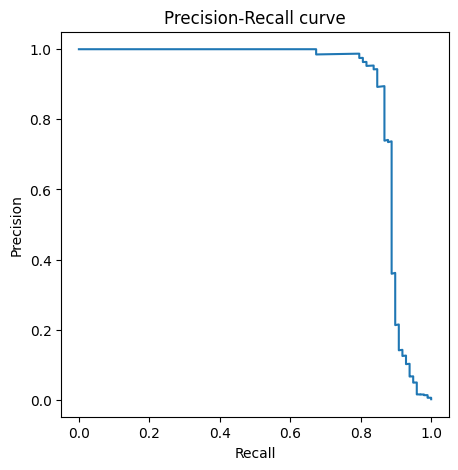

In [58]:
result_lgb = evaluate_model(model_lgb, X_test, y_test)

In [67]:
model_lgb.booster_.save_model(os.path.join(FOLDER_TO_SAVE_MODELS,f"LGB-{datetime.now().strftime('%Y%m%d')}.txt"))

# Example to load model
# loaded_model_lgb = lgb.Booster(model_file='mode.txt')

### Model comparison

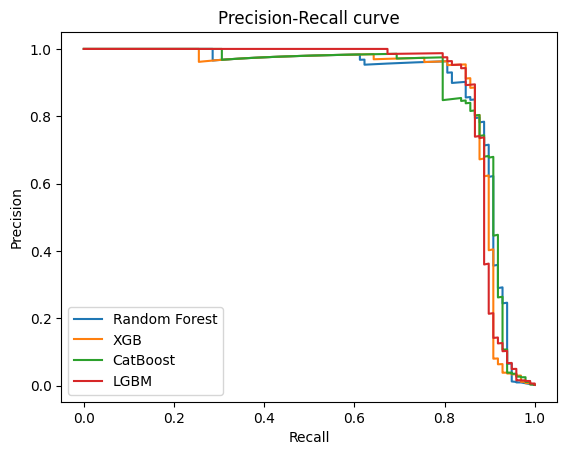

In [59]:
results= {
    'Random Forest':result_rf,
    'XGB':result_xgb,
    'CatBoost':result_cb,
    'LGBM':result_lgb
}

f,ax = plt.subplots(1)

for result in results.items():
    ax.plot(result[1][2], result[1][3], label=result[0])

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall curve')

ax.legend(loc='lower left')
plt.show()

In [60]:
aucpr_dict = dict()
for result in results.items():
    aucpr_dict[result[0]] = [result[1][1]]

aucpr_df = pd.DataFrame(aucpr_dict).T
aucpr_df.columns = ['AUCPR score']
aucpr_df

,AUCPR score
Random Forest,0.884953
XGB,0.877661
CatBoost,0.884663
LGBM,0.887724


In [61]:
def create_df(results_dict, relevant_cols):
    # Initialize an empty dataframe
    merged_df = pd.DataFrame()

    # Iterate through the list of tuples and merge the dataframes
    for name, df in [(result[0], result[1][0]) for result in results_dict.items()]:
        if merged_df.empty:
            merged_df = df[['threshold']].copy()
            merged_df.columns = pd.MultiIndex.from_tuples([('', col) for col in merged_df.columns])
        
        df = df[relevant_cols]
        df.columns = pd.MultiIndex.from_tuples([(name, col) for col in df.columns])
        merged_df = merged_df.merge(df, left_index=True, right_index=True, how='outer')
        
    return merged_df

create_df(results_dict=results, relevant_cols=['precision','recall'])    

Random Forest                 XGB            CatBoost            \
  threshold     precision    recall precision    recall precision    recall   
0       0.1      0.955224  0.653061  0.952381  0.816327  0.939759  0.795918   
1       0.2      0.961039  0.755102  0.954023  0.846939  0.847826  0.795918   
2       0.3      0.962500  0.785714  0.913043  0.857143  0.851064  0.816327   
3       0.4      0.929412  0.806122  0.893617  0.857143  0.838384  0.846939   
4       0.5      0.892473  0.846939  0.885417  0.867347  0.840000  0.857143   
5       0.6      0.848485  0.857143  0.817308  0.867347  0.831683  0.857143   
6       0.7      0.825243  0.867347  0.801887  0.867347  0.796296  0.877551   
7       0.8      0.781818  0.877551  0.741379  0.877551  0.754386  0.877551   
8       0.9      0.676923  0.897959  0.639706  0.887755  0.640288  0.908163   

       LGBM            
  precision    recall  
0  0.986667  0.755102  
1  0.987013  0.775510  
2  0.963415  0.806122  
3  0.963855  0.816327  
4  0.952381  0.816327  
5  0.953488  0.836735  
6  0.942529  0.836735  
7  0.942529  0.836735  
8  0.892473  0.846939

In [62]:
create_df(results_dict=results, relevant_cols=['FN','FP','TP','TN'])    

Random Forest                XGB                CatBoost          \
  threshold            FN  FP  TP     TN  FN  FP  TP     TN       FN  FP  TP   
0       0.1            34   3  64  56861  18   4  80  56860       20   5  78   
1       0.2            24   3  74  56861  15   4  83  56860       20  14  78   
2       0.3            21   3  77  56861  14   8  84  56856       18  14  80   
3       0.4            19   6  79  56858  14  10  84  56854       15  16  83   
4       0.5            15  10  83  56854  13  11  85  56853       14  16  84   
5       0.6            14  15  84  56849  13  19  85  56845       14  17  84   
6       0.7            13  18  85  56846  13  21  85  56843       12  22  86   
7       0.8            12  24  86  56840  12  30  86  56834       12  28  86   
8       0.9            10  42  88  56822  11  49  87  56815        9  50  89   

         LGBM                 
      TN   FN  FP  TP     TN  
0  56859   24   1  74  56863  
1  56850   22   1  76  56863  
2  56850   19   3  79  56861  
3  56848   18   3  80  56861  
4  56848   18   4  80  56860  
5  56847   16   4  82  56860  
6  56842   16   5  82  56859  
7  56836   16   5  82  56859  
8  56814   15  10  83  56854

In [64]:
# Create a scatter plot for each dataset
fig = go.Figure()


for result in results.items():
    # Create custom hover text with the additional information
    hover_text = [f"{result[0]} at {info:.1f} threshold" for info in result[1][0]['threshold']]

    fig.add_trace(go.Scatter(
        x=result[1][0]['FP'], 
        y=result[1][0]['FN'], 
        mode='markers', 
        name=result[0],
        text=hover_text  # Assign the custom hover text here
    ))

    fig.add_shape(type="rect",
    xref="x", yref="y",
    x0=0, y0=0,
    x1=50, y1=15,
    fillcolor="green",
    opacity=0.1
    )


# Customize the layout, axis labels, and size
fig.update_layout(
    title='Scatter Plot',
    xaxis_title='FP - incorrectly classified as fraudulent',
    yaxis_title='FN- incorrectly classified as nonfraudulent',
    width=800,
    height=600
)

# Show the plot
fig.show()


### Conclusion:

We have achieved satisfactory predictive performance using all four models, despite the extremely imbalanced dataset.

I've highlighted the promising results on the above plot with a green rectangle based on my intuition. However, our ultimate decision regarding model selection and the threshold could depend on several crucial factors. For example, in a real-world scenario, the cost of misclassifying a fraudulent case as non-fraudulent may be significantly higher than misclassifying a non-fraudulent case as fraudulent. In such cases, further fine-tuning of the models is necessary, with a greater emphasis on recall rather than the overall AUCPR score."